In [ ]:
import os
import scanpy as sc

In [ ]:
cd "/home/dslab_cth/scLightGAT"

/home/dslab_cth/scLightGAT


/Group16T/common/cth/anaconda3/envs/scrna/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# scLightGAT(Major type)

In [ ]:
# --- 0) Reload your edited modules (English comments) ---
import importlib
import scLightGAT.preprocess.preprocess as preproc
import scLightGAT.preprocess.prediction_preprocess as predprep
import scLightGAT.training.model_manager as mm

importlib.reload(preproc)   # if you patched visualization_process to auto-detect X_pca_harmony
importlib.reload(predprep)
importlib.reload(mm)

# --- 1) Helper: attach Harmony PCs into obsm['X_pca_harmony'] ---
import scanpy as sc
import pandas as pd
import harmonypy as hm

def attach_harmony_with_harmonypy(adata, batch_key: str, n_pcs: int = 50, theta: float = 2.0):
    """
    Run PCA then Harmony (harmonypy) and store corrected PCs in adata.obsm['X_pca_harmony'].
    - batch_key must be a column in adata.obs (e.g., 'orig.ident', 'batch', 'sample').
    - theta controls strength of correction (higher = more conservative).
    """
    # 0) basic checks
    if batch_key not in adata.obs.columns:
        raise KeyError(f"batch_key '{batch_key}' not in adata.obs")

    # 1) make sure PCA exists
    if 'X_pca' not in adata.obsm:
        sc.pp.pca(adata, n_comps=n_pcs)

    # 2) run Harmony on PCA
    data_mat = adata.obsm['X_pca']                  # shape: (n_cells, n_pcs)
    meta_data = adata.obs                           # pandas DataFrame
    ho = hm.run_harmony(
        data_mat,
        meta_data,
        [batch_key],
        max_iter_harmony=50,
        theta=theta,              # <-- tune this if clusters look over-integrated
        plot_convergence=False    # set True if you want the plot
    )

    # 3) harmonypy returns Z_corr with shape (n_pcs, n_cells) -> transpose back
    adjusted_pcs = pd.DataFrame(ho.Z_corr).T
    adata.obsm['X_pca_harmony'] = adjusted_pcs.values

    return adata

# --- 2) Load data ---
adata_train = sc.read_h5ad("/home/dslab_cth/scLightGAT/data/Integrated_training/train.h5ad")
adata_test  = sc.read_h5ad("/home/dslab_cth/scLightGAT/data/Independent_testing/GSE153935.h5ad")

# --- 3)  Run Harmony upfront; set your obs batch column name here ---
# BATCH_KEY = "batch"
# attach_harmony_pca(adata_train, batch_key='batch')
# attach_harmony_with_harmonypy(adata_test, batch_key='Seq.Batch.ID', n_pcs=50, theta=4.0)
# --- 4) Run pipeline (turn on hierarchical to enable subtype) ---
from scLightGAT.training.model_manager import CellTypeAnnotator

annotator = CellTypeAnnotator(
    use_dvae=True,
    gat_epochs=300,
    dvae_params={'epochs': 10},
    hierarchical=False
)


# run_pipeline will use that for neighbor graph / UMAP
adata_result, dvae_losses, gat_losses = annotator.run_pipeline(
    adata_train,
    adata_test,
    use_gat=True
)

# --- 5) Sanitize before writing (avoid pandas StringDtype in obs) ---
# Try importing the shared function; if not available, fall back to local definition.
try:
    from scLightGAT.pipeline import sanitize_obs_for_h5ad
except Exception:
    # Local fallback: HDF5-safe casting for AnnData.obs
    import numpy as np
    import pandas as pd
    def sanitize_obs_for_h5ad(adata):
        # convert pandas 'string' dtype columns -> object
        for c in list(adata.obs.select_dtypes(include=['string']).columns):
            adata.obs[c] = adata.obs[c].astype(object)
        # ensure categoricals have object-based categories (not StringArray)
        for c in adata.obs.columns:
            if pd.api.types.is_categorical_dtype(adata.obs[c]):
                cat = adata.obs[c].cat
                new_cats = np.asarray(cat.categories.astype(object))
                adata.obs[c] = pd.Categorical(adata.obs[c].astype(str), categories=new_cats)

sanitize_obs_for_h5ad(adata_result)
adata_result.write("/home/dslab_cth/scLightGAT/results/adata_with_predictions.h5ad")
print("Saved to /home/dslab_cth/scLightGAT/results/adata_with_predictions.h5ad")


2025-10-22 16:22:23 - INFO - scLightGAT.training.model_manager - CellTypeAnnotator initialized on device: cuda
2025-10-22 16:22:23 - INFO - scLightGAT.training.model_manager - DVAE enabled: True, HVG enabled: True
2025-10-22 16:22:23 - INFO - scLightGAT.training.model_manager - Hierarchical classification: False
2025-10-22 16:22:23 - INFO - scLightGAT.training.model_manager - Starting complete annotation pipeline
2025-10-22 16:22:23 - INFO - scLightGAT.training.model_manager - Starting feature extraction
2025-10-22 16:22:23 - INFO - scLightGAT.preprocess.prediction_preprocess - 💾Preparing data for all models
2025-10-22 16:22:28 - INFO - scLightGAT.preprocess.prediction_preprocess - ⏰Preparing DGEs data
2025-10-22 16:22:28 - INFO - scLightGAT.preprocess.prediction_preprocess - Performing feature selection using Celltype_training


/Group16T/common/cth/anaconda3/envs/scrna/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


2025-10-22 16:22:44 - INFO - scLightGAT.preprocess.prediction_preprocess - Generating feature list with top 3000 features
2025-10-22 16:22:44 - INFO - scLightGAT.preprocess.prediction_preprocess - 🧬Number of common DGEs: 851🧬
2025-10-22 16:22:48 - INFO - scLightGAT.preprocess.prediction_preprocess - Final shape of adata_train_dge: (158681, 851)
2025-10-22 16:22:48 - INFO - scLightGAT.preprocess.prediction_preprocess - Final shape of adata_test_dge: (8030, 851)
2025-10-22 16:22:48 - INFO - scLightGAT.preprocess.prediction_preprocess - ⏰Preparing HVG data


/Group16T/common/cth/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


2025-10-22 16:22:54 - INFO - scLightGAT.preprocess.prediction_preprocess - 🧬Number of common HVGs: 2872🧬
2025-10-22 16:22:59 - INFO - scLightGAT.preprocess.prediction_preprocess - Final shape of adata_train_hvg: (158681, 2872)
2025-10-22 16:22:59 - INFO - scLightGAT.preprocess.prediction_preprocess - Final shape of adata_test_hvg: (8030, 2872)
2025-10-22 16:22:59 - INFO - scLightGAT.preprocess.prediction_preprocess - 💾Preparing data for LightGBM
2025-10-22 16:22:59 - INFO - scLightGAT.preprocess.prediction_preprocess - Transforming AnnData object for Celltype_training
2025-10-22 16:23:00 - INFO - scLightGAT.preprocess.prediction_preprocess - 💾Preparing data for DVAE
2025-10-22 16:23:00 - INFO - scLightGAT.preprocess.prediction_preprocess - Transforming AnnData object for Celltype_training
2025-10-22 16:23:02 - INFO - scLightGAT.preprocess.prediction_preprocess - Balancing classes with target count 10000
2025-10-22 16:23:02 - INFO - scLightGAT.preprocess.prediction_preprocess - Original

/home/dslab_cth/scLightGAT/scLightGAT/training/model_manager.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/1240 [00:00<?, ?it/s]/home/dslab_cth/scLightGAT/scLightGAT/training/model_manager.py:217: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/dslab_cth/scLightGAT/scLightGAT/training/model_manager.py:223: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  batch_labels = torch.tensor(
Epoch 5/10: 100%|██████████| 1240/1240 [00:20<00:00, 60.47it/s]

2025-10-22 16:24:42 - INFO - scLightGAT.training.model_manager - Epoch [5/10], Loss: 0.2272, LR: 0.000005



Epoch 10/10: 100%|██████████| 1240/1240 [00:27<00:00, 45.68it/s]

2025-10-22 16:26:35 - INFO - scLightGAT.training.model_manager - Epoch [10/10], Loss: 0.1506, LR: 0.000001


2025-10-22 16:26:36 - INFO - scLightGAT.training.model_manager - DVAE training completed
2025-10-22 16:26:37 - INFO - scLightGAT.training.model_manager - Transforming AnnData for Celltype_training
2025-10-22 16:26:37 - INFO - scLightGAT.training.model_manager - Transforming AnnData for Celltype_training
2025-10-22 16:26:39 - INFO - scLightGAT.preprocess.prediction_preprocess - Balancing classes with target count 10000
2025-10-22 16:26:39 - INFO - scLightGAT.preprocess.prediction_preprocess - Original class counts:
encoding
5     36458
7     32291
1     24899
4     12856
6     10649
10     9373
0      6964
2      6274
9      5294
11     4583
3      4470
8      4138
12      432
Name: count, dtype: int64
2025-10-22 16:26:51 - INFO - scLightGAT.preprocess.prediction_preprocess - 🔧Resampled class counts:
encoding
0     10000
1     10000
2     10000
3     10000
4     10000
5     10000
6     10000
7     10000
8     10000
9     10000
10    10000
11    10000
12    10000
Name: count, dtype: int6

/home/dslab_cth/scLightGAT/scLightGAT/preprocess/preprocess.py:111: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=res)


2025-10-22 16:29:05 - INFO - scLightGAT.preprocess.preprocess - ✅Visualization process completed
Neighbors rep used: X_pca
Has X_pca_harmony: False
2025-10-22 16:29:05 - INFO - scLightGAT.training.model_manager - Preparing data for GAT
2025-10-22 16:29:05 - INFO - scLightGAT.training.model_manager - GAT model initialized with 917 in_channels and 13 out_channels
2025-10-22 16:29:05 - INFO - scLightGAT.training.model_manager - Starting GAT training


/home/dslab_cth/scLightGAT/scLightGAT/models/gat_model.py:114: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training GAT:   0%|          | 0/300 [00:00<?, ?it/s]/home/dslab_cth/scLightGAT/scLightGAT/models/gat_model.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training GAT:   3%|▎         | 9/300 [00:06<03:03,  1.58it/s, loss=0.3543]

2025-10-22 16:29:11 - INFO - scLightGAT.models.gat_model - Epoch [10/300], Loss: 0.3543


Training GAT:   6%|▋         | 19/300 [00:12<02:57,  1.58it/s, loss=0.3154]

2025-10-22 16:29:18 - INFO - scLightGAT.models.gat_model - Epoch [20/300], Loss: 0.3154


Training GAT:  10%|▉         | 29/300 [00:19<02:51,  1.58it/s, loss=0.2990]

2025-10-22 16:29:24 - INFO - scLightGAT.models.gat_model - Epoch [30/300], Loss: 0.2990


Training GAT:  13%|█▎        | 39/300 [00:25<02:45,  1.58it/s, loss=0.2869]

2025-10-22 16:29:30 - INFO - scLightGAT.models.gat_model - Epoch [40/300], Loss: 0.2869


Training GAT:  16%|█▋        | 49/300 [00:31<02:37,  1.59it/s, loss=0.2822]

2025-10-22 16:29:37 - INFO - scLightGAT.models.gat_model - Epoch [50/300], Loss: 0.2822


Training GAT:  20%|█▉        | 59/300 [00:38<02:31,  1.59it/s, loss=0.2809]

2025-10-22 16:29:43 - INFO - scLightGAT.models.gat_model - Epoch [60/300], Loss: 0.2809


Training GAT:  23%|██▎       | 69/300 [00:44<02:25,  1.59it/s, loss=0.2725]

2025-10-22 16:29:49 - INFO - scLightGAT.models.gat_model - Epoch [70/300], Loss: 0.2725


Training GAT:  26%|██▋       | 79/300 [00:50<02:18,  1.59it/s, loss=0.2646]

2025-10-22 16:29:56 - INFO - scLightGAT.models.gat_model - Epoch [80/300], Loss: 0.2646


Training GAT:  30%|██▉       | 89/300 [00:57<02:13,  1.58it/s, loss=0.2671]

2025-10-22 16:30:02 - INFO - scLightGAT.models.gat_model - Epoch [90/300], Loss: 0.2671


Training GAT:  33%|███▎      | 99/300 [01:03<02:07,  1.58it/s, loss=0.2621]

2025-10-22 16:30:08 - INFO - scLightGAT.models.gat_model - Epoch [100/300], Loss: 0.2621


Training GAT:  36%|███▋      | 109/300 [01:09<02:00,  1.58it/s, loss=0.2553]

2025-10-22 16:30:15 - INFO - scLightGAT.models.gat_model - Epoch [110/300], Loss: 0.2553


Training GAT:  40%|███▉      | 119/300 [01:16<01:54,  1.58it/s, loss=0.2549]

2025-10-22 16:30:21 - INFO - scLightGAT.models.gat_model - Epoch [120/300], Loss: 0.2549


Training GAT:  43%|████▎     | 129/300 [01:22<01:48,  1.58it/s, loss=0.2436]

2025-10-22 16:30:28 - INFO - scLightGAT.models.gat_model - Epoch [130/300], Loss: 0.2436


Training GAT:  46%|████▋     | 139/300 [01:29<01:42,  1.58it/s, loss=0.2469]

2025-10-22 16:30:34 - INFO - scLightGAT.models.gat_model - Epoch [140/300], Loss: 0.2469


Training GAT:  50%|████▉     | 149/300 [01:35<01:35,  1.58it/s, loss=0.2552]

2025-10-22 16:30:40 - INFO - scLightGAT.models.gat_model - Epoch [150/300], Loss: 0.2552


Training GAT:  53%|█████▎    | 159/300 [01:41<01:29,  1.58it/s, loss=0.2342]

2025-10-22 16:30:47 - INFO - scLightGAT.models.gat_model - Epoch [160/300], Loss: 0.2342


Training GAT:  56%|█████▋    | 169/300 [01:48<01:23,  1.58it/s, loss=0.2369]

2025-10-22 16:30:53 - INFO - scLightGAT.models.gat_model - Epoch [170/300], Loss: 0.2369


Training GAT:  60%|█████▉    | 179/300 [01:54<01:16,  1.58it/s, loss=0.2336]

2025-10-22 16:30:59 - INFO - scLightGAT.models.gat_model - Epoch [180/300], Loss: 0.2336


Training GAT:  63%|██████▎   | 189/300 [02:00<01:10,  1.58it/s, loss=0.2301]

2025-10-22 16:31:06 - INFO - scLightGAT.models.gat_model - Epoch [190/300], Loss: 0.2301


Training GAT:  66%|██████▋   | 199/300 [02:07<01:04,  1.57it/s, loss=0.2201]

2025-10-22 16:31:12 - INFO - scLightGAT.models.gat_model - Epoch [200/300], Loss: 0.2201


Training GAT:  70%|██████▉   | 209/300 [02:13<00:57,  1.58it/s, loss=0.2223]

2025-10-22 16:31:19 - INFO - scLightGAT.models.gat_model - Epoch [210/300], Loss: 0.2223


Training GAT:  71%|███████   | 212/300 [02:14<00:56,  1.56it/s, loss=0.2227]

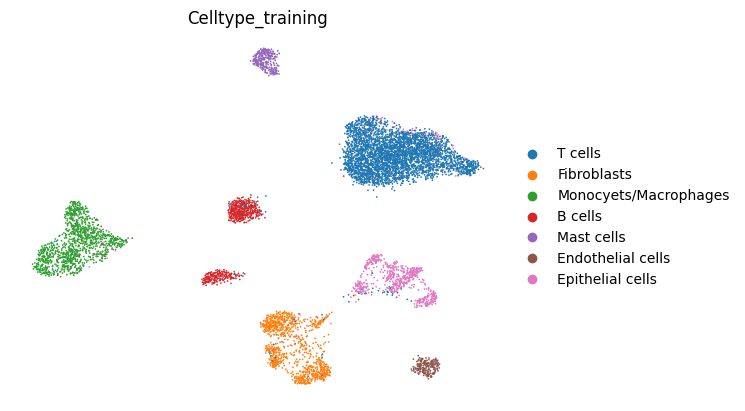

In [ ]:
adata_result
sc.pl.umap(adata_result,color=['Celltype_training', 'scLightGAT_prediction'],title=['Celltype_training'],frameon = False, legend_loc = 'right margin',save=True,size =6)

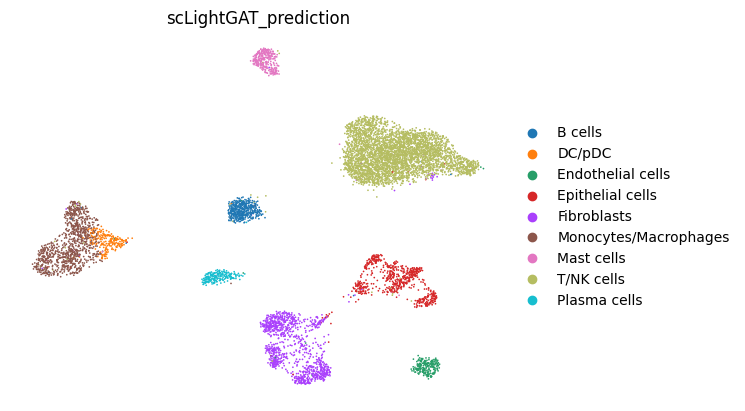

In [ ]:
adata_result
sc.pl.umap(adata_result,color=['scLightGAT_prediction'],title=['scLightGAT_prediction'],frameon = False, legend_loc = 'right margin',save=True,size =6)

# scLightGAT(Subtype)

2025-10-22 15:37:00 - INFO - scLightGAT.pipeline - [TRAIN MODE] Starting training pipeline
2025-10-22 15:37:00 - INFO - scLightGAT.pipeline - Train data: /home/dslab_cth/scLightGAT/data/Integrated_training/train.h5ad
2025-10-22 15:37:00 - INFO - scLightGAT.pipeline - Test data: /home/dslab_cth/scLightGAT/data/Independent_testing/GSE153935.h5ad
2025-10-22 15:37:00 - INFO - scLightGAT.pipeline - Output dir: /home/dslab_cth/scLightGAT/results/GSE153935
2025-10-22 15:37:00 - INFO - scLightGAT.pipeline - Model save dir: /home/dslab_cth/scLightGAT/models
2025-10-22 15:37:00 - INFO - scLightGAT.pipeline - Train DVAE: True, Use GAT: True, DVAE Epochs: 3, GAT Epochs: 300
2025-10-22 15:37:00 - INFO - scLightGAT.pipeline - Hierarchical mode: True


2025-10-22 15:37:03 - INFO - scLightGAT.training.model_manager - CellTypeAnnotator initialized on device: cuda
2025-10-22 15:37:03 - INFO - scLightGAT.training.model_manager - DVAE enabled: True, HVG enabled: True
2025-10-22 15:37:03 - INFO - scLightGAT.training.model_manager - Hierarchical classification: True
2025-10-22 15:37:03 - INFO - scLightGAT.training.model_manager - Starting complete annotation pipeline
2025-10-22 15:37:03 - INFO - scLightGAT.training.model_manager - Starting feature extraction
2025-10-22 15:37:03 - INFO - scLightGAT.preprocess.prediction_preprocess - 💾Preparing data for all models
2025-10-22 15:37:07 - INFO - scLightGAT.preprocess.prediction_preprocess - ⏰Preparing DGEs data
2025-10-22 15:37:07 - INFO - scLightGAT.preprocess.prediction_preprocess - Performing feature selection using Celltype_training
2025-10-22 15:37:26 - INFO - scLightGAT.preprocess.prediction_preprocess - Generating feature list with top 3000 features
2025-10-22 15:37:26 - INFO - scLightGAT

/Group16T/common/cth/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


2025-10-22 15:37:36 - INFO - scLightGAT.preprocess.prediction_preprocess - 🧬Number of common HVGs: 2872🧬
2025-10-22 15:37:42 - INFO - scLightGAT.preprocess.prediction_preprocess - Final shape of adata_train_hvg: (158681, 2872)
2025-10-22 15:37:42 - INFO - scLightGAT.preprocess.prediction_preprocess - Final shape of adata_test_hvg: (8030, 2872)
2025-10-22 15:37:42 - INFO - scLightGAT.preprocess.prediction_preprocess - 💾Preparing data for LightGBM
2025-10-22 15:37:42 - INFO - scLightGAT.preprocess.prediction_preprocess - Transforming AnnData object for Celltype_training
2025-10-22 15:37:43 - INFO - scLightGAT.preprocess.prediction_preprocess - 💾Preparing data for DVAE
2025-10-22 15:37:43 - INFO - scLightGAT.preprocess.prediction_preprocess - Transforming AnnData object for Celltype_training
2025-10-22 15:37:45 - INFO - scLightGAT.preprocess.prediction_preprocess - Balancing classes with target count 10000
2025-10-22 15:37:45 - INFO - scLightGAT.preprocess.prediction_preprocess - Original

/home/dslab_cth/scLightGAT/scLightGAT/training/model_manager.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/3:   0%|          | 0/1240 [00:00<?, ?it/s]/home/dslab_cth/scLightGAT/scLightGAT/training/model_manager.py:217: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/dslab_cth/scLightGAT/scLightGAT/training/model_manager.py:223: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  batch_labels = torch.tensor(
Epoch 3/3: 100%|██████████| 1240/1240 [00:25<00:00, 49.41it/s]


2025-10-22 15:39:05 - INFO - scLightGAT.training.model_manager - DVAE training completed
2025-10-22 15:39:05 - INFO - scLightGAT.training.model_manager - Transforming AnnData for Celltype_training
2025-10-22 15:39:05 - INFO - scLightGAT.training.model_manager - Transforming AnnData for Celltype_training
2025-10-22 15:39:07 - INFO - scLightGAT.preprocess.prediction_preprocess - Balancing classes with target count 10000
2025-10-22 15:39:07 - INFO - scLightGAT.preprocess.prediction_preprocess - Original class counts:
encoding
5     36458
7     32291
1     24899
4     12856
6     10649
10     9373
0      6964
2      6274
9      5294
11     4583
3      4470
8      4138
12      432
Name: count, dtype: int64
2025-10-22 15:39:11 - INFO - scLightGAT.preprocess.prediction_preprocess - 🔧Resampled class counts:
encoding
0     10000
1     10000
2     10000
3     10000
4     10000
5     10000
6     10000
7     10000
8     10000
9     10000
10    10000
11    10000
12    10000
Name: count, dtype: int6

/home/dslab_cth/scLightGAT/scLightGAT/models/gat_model.py:114: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training GAT:   0%|          | 0/300 [00:00<?, ?it/s]/home/dslab_cth/scLightGAT/scLightGAT/models/gat_model.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training GAT:   3%|▎         | 9/300 [00:05<03:01,  1.61it/s, loss=0.3654]

2025-10-22 15:40:37 - INFO - scLightGAT.models.gat_model - Epoch [10/300], Loss: 0.3654


Training GAT:   6%|▋         | 19/300 [00:12<02:57,  1.58it/s, loss=0.3260]

2025-10-22 15:40:44 - INFO - scLightGAT.models.gat_model - Epoch [20/300], Loss: 0.3260


Training GAT:  10%|▉         | 29/300 [00:18<02:51,  1.58it/s, loss=0.3047]

2025-10-22 15:40:50 - INFO - scLightGAT.models.gat_model - Epoch [30/300], Loss: 0.3047


Training GAT:  13%|█▎        | 39/300 [00:24<02:44,  1.59it/s, loss=0.2841]

2025-10-22 15:40:56 - INFO - scLightGAT.models.gat_model - Epoch [40/300], Loss: 0.2841


Training GAT:  16%|█▋        | 49/300 [00:31<02:37,  1.59it/s, loss=0.2724]

2025-10-22 15:41:03 - INFO - scLightGAT.models.gat_model - Epoch [50/300], Loss: 0.2724


Training GAT:  20%|█▉        | 59/300 [00:37<02:31,  1.59it/s, loss=0.2707]

2025-10-22 15:41:09 - INFO - scLightGAT.models.gat_model - Epoch [60/300], Loss: 0.2707


Training GAT:  23%|██▎       | 69/300 [00:43<02:26,  1.58it/s, loss=0.2638]

2025-10-22 15:41:15 - INFO - scLightGAT.models.gat_model - Epoch [70/300], Loss: 0.2638


Training GAT:  26%|██▋       | 79/300 [00:50<02:19,  1.58it/s, loss=0.2624]

2025-10-22 15:41:22 - INFO - scLightGAT.models.gat_model - Epoch [80/300], Loss: 0.2624


Training GAT:  30%|██▉       | 89/300 [00:56<02:13,  1.58it/s, loss=0.2569]

2025-10-22 15:41:28 - INFO - scLightGAT.models.gat_model - Epoch [90/300], Loss: 0.2569


Training GAT:  33%|███▎      | 99/300 [01:03<02:07,  1.58it/s, loss=0.2525]

2025-10-22 15:41:34 - INFO - scLightGAT.models.gat_model - Epoch [100/300], Loss: 0.2525


Training GAT:  36%|███▋      | 109/300 [01:09<02:00,  1.58it/s, loss=0.2519]

2025-10-22 15:41:41 - INFO - scLightGAT.models.gat_model - Epoch [110/300], Loss: 0.2519


Training GAT:  40%|███▉      | 119/300 [01:15<01:54,  1.58it/s, loss=0.2469]

2025-10-22 15:41:47 - INFO - scLightGAT.models.gat_model - Epoch [120/300], Loss: 0.2469


Training GAT:  43%|████▎     | 129/300 [01:22<01:48,  1.58it/s, loss=0.2467]

2025-10-22 15:41:53 - INFO - scLightGAT.models.gat_model - Epoch [130/300], Loss: 0.2467


Training GAT:  46%|████▋     | 139/300 [01:28<01:42,  1.58it/s, loss=0.2411]

2025-10-22 15:42:00 - INFO - scLightGAT.models.gat_model - Epoch [140/300], Loss: 0.2411


Training GAT:  50%|████▉     | 149/300 [01:34<01:35,  1.57it/s, loss=0.2351]

2025-10-22 15:42:06 - INFO - scLightGAT.models.gat_model - Epoch [150/300], Loss: 0.2351


Training GAT:  53%|█████▎    | 159/300 [01:41<01:29,  1.57it/s, loss=0.2300]

2025-10-22 15:42:13 - INFO - scLightGAT.models.gat_model - Epoch [160/300], Loss: 0.2300


Training GAT:  56%|█████▋    | 169/300 [01:47<01:23,  1.57it/s, loss=0.2350]

2025-10-22 15:42:19 - INFO - scLightGAT.models.gat_model - Epoch [170/300], Loss: 0.2350


Training GAT:  60%|█████▉    | 179/300 [01:54<01:16,  1.58it/s, loss=0.2340]

2025-10-22 15:42:25 - INFO - scLightGAT.models.gat_model - Epoch [180/300], Loss: 0.2340


Training GAT:  63%|██████▎   | 189/300 [02:00<01:10,  1.57it/s, loss=0.2277]

2025-10-22 15:42:32 - INFO - scLightGAT.models.gat_model - Epoch [190/300], Loss: 0.2277


Training GAT:  66%|██████▋   | 199/300 [02:06<01:04,  1.57it/s, loss=0.2258]

2025-10-22 15:42:38 - INFO - scLightGAT.models.gat_model - Epoch [200/300], Loss: 0.2258


Training GAT:  70%|██████▉   | 209/300 [02:13<00:57,  1.57it/s, loss=0.2218]

2025-10-22 15:42:45 - INFO - scLightGAT.models.gat_model - Epoch [210/300], Loss: 0.2218


Training GAT:  73%|███████▎  | 219/300 [02:19<00:51,  1.57it/s, loss=0.2159]

2025-10-22 15:42:51 - INFO - scLightGAT.models.gat_model - Epoch [220/300], Loss: 0.2159


Training GAT:  76%|███████▋  | 229/300 [02:26<00:45,  1.57it/s, loss=0.2132]

2025-10-22 15:42:57 - INFO - scLightGAT.models.gat_model - Epoch [230/300], Loss: 0.2132


Training GAT:  80%|███████▉  | 239/300 [02:32<00:38,  1.57it/s, loss=0.2176]

2025-10-22 15:43:04 - INFO - scLightGAT.models.gat_model - Epoch [240/300], Loss: 0.2176


Training GAT:  83%|████████▎ | 249/300 [02:38<00:32,  1.57it/s, loss=0.2163]

2025-10-22 15:43:10 - INFO - scLightGAT.models.gat_model - Epoch [250/300], Loss: 0.2163


Training GAT:  86%|████████▋ | 259/300 [02:45<00:26,  1.57it/s, loss=0.2082]

2025-10-22 15:43:17 - INFO - scLightGAT.models.gat_model - Epoch [260/300], Loss: 0.2082


Training GAT:  90%|████████▉ | 269/300 [02:51<00:19,  1.57it/s, loss=0.2060]

2025-10-22 15:43:23 - INFO - scLightGAT.models.gat_model - Epoch [270/300], Loss: 0.2060


Training GAT:  93%|█████████▎| 279/300 [02:58<00:13,  1.57it/s, loss=0.2029]

2025-10-22 15:43:29 - INFO - scLightGAT.models.gat_model - Epoch [280/300], Loss: 0.2029


Training GAT:  96%|█████████▋| 289/300 [03:04<00:07,  1.57it/s, loss=0.2021]

2025-10-22 15:43:36 - INFO - scLightGAT.models.gat_model - Epoch [290/300], Loss: 0.2021


Training GAT: 100%|█████████▉| 299/300 [03:10<00:00,  1.57it/s, loss=0.2087]

2025-10-22 15:43:42 - INFO - scLightGAT.models.gat_model - Epoch [300/300], Loss: 0.2087


Training GAT: 100%|██████████| 300/300 [03:10<00:00,  1.57it/s, loss=0.2087]

2025-10-22 15:43:42 - INFO - scLightGAT.training.model_manager - GAT training completed



/home/dslab_cth/scLightGAT/scLightGAT/models/gat_model.py:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


2025-10-22 15:43:42 - INFO - scLightGAT.models.gat_model - Accuracy (GAT vs LightGBM labels): 0.9330
2025-10-22 15:43:42 - INFO - scLightGAT.training.model_manager - GAT Refinement completed with accuracy: 0.9330
2025-10-22 15:43:42 - INFO - scLightGAT.training.model_manager - Starting subtype prediction
2025-10-22 15:43:43 - INFO - scLightGAT.training.model_manager - Processing CD4+T cells
2025-10-22 15:43:43 - INFO - scLightGAT.preprocess.prediction_preprocess - Preparing subtype data for CD4+T cells
2025-10-22 15:43:43 - INFO - scLightGAT.preprocess.prediction_preprocess - Performing feature selection using Celltype_subtraining
2025-10-22 15:43:44 - INFO - scLightGAT.preprocess.prediction_preprocess - Generating feature list with top 1000 features
2025-10-22 15:43:44 - INFO - scLightGAT.training.model_manager - Transforming AnnData for Celltype_subtraining
2025-10-22 15:43:44 - INFO - scLightGAT.training.model_manager - Transforming AnnData for Celltype_training
2025-10-22 15:43:44 

/home/dslab_cth/scLightGAT/scLightGAT/models/gat_model.py:114: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training GAT:   0%|          | 0/300 [00:00<?, ?it/s]/home/dslab_cth/scLightGAT/scLightGAT/models/gat_model.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training GAT:   3%|▎         | 9/300 [00:02<01:07,  4.34it/s, loss=2.3303]

2025-10-22 15:44:05 - INFO - scLightGAT.models.gat_model - Epoch [10/300], Loss: 2.3303


Training GAT:   6%|▋         | 19/300 [00:04<01:07,  4.15it/s, loss=2.1826]

2025-10-22 15:44:07 - INFO - scLightGAT.models.gat_model - Epoch [20/300], Loss: 2.1826


Training GAT:  10%|▉         | 29/300 [00:06<01:05,  4.13it/s, loss=2.1332]

2025-10-22 15:44:10 - INFO - scLightGAT.models.gat_model - Epoch [30/300], Loss: 2.1332


Training GAT:  13%|█▎        | 39/300 [00:09<01:02,  4.16it/s, loss=2.1066]

2025-10-22 15:44:12 - INFO - scLightGAT.models.gat_model - Epoch [40/300], Loss: 2.1066


Training GAT:  16%|█▋        | 49/300 [00:11<01:00,  4.13it/s, loss=2.0608]

2025-10-22 15:44:14 - INFO - scLightGAT.models.gat_model - Epoch [50/300], Loss: 2.0608


Training GAT:  20%|█▉        | 59/300 [00:14<00:58,  4.15it/s, loss=2.0491]

2025-10-22 15:44:17 - INFO - scLightGAT.models.gat_model - Epoch [60/300], Loss: 2.0491


Training GAT:  23%|██▎       | 69/300 [00:16<00:56,  4.12it/s, loss=2.0299]

2025-10-22 15:44:19 - INFO - scLightGAT.models.gat_model - Epoch [70/300], Loss: 2.0299


Training GAT:  26%|██▋       | 79/300 [00:19<00:53,  4.15it/s, loss=2.0192]

2025-10-22 15:44:22 - INFO - scLightGAT.models.gat_model - Epoch [80/300], Loss: 2.0192


Training GAT:  30%|██▉       | 89/300 [00:21<00:51,  4.11it/s, loss=2.0109]

2025-10-22 15:44:24 - INFO - scLightGAT.models.gat_model - Epoch [90/300], Loss: 2.0109


Training GAT:  33%|███▎      | 99/300 [00:23<00:48,  4.13it/s, loss=1.9916]

2025-10-22 15:44:27 - INFO - scLightGAT.models.gat_model - Epoch [100/300], Loss: 1.9916


Training GAT:  36%|███▋      | 109/300 [00:26<00:46,  4.11it/s, loss=1.9848]

2025-10-22 15:44:29 - INFO - scLightGAT.models.gat_model - Epoch [110/300], Loss: 1.9848


Training GAT:  40%|███▉      | 119/300 [00:28<00:44,  4.10it/s, loss=1.9716]

2025-10-22 15:44:31 - INFO - scLightGAT.models.gat_model - Epoch [120/300], Loss: 1.9716


Training GAT:  43%|████▎     | 129/300 [00:31<00:41,  4.10it/s, loss=1.9601]

2025-10-22 15:44:34 - INFO - scLightGAT.models.gat_model - Epoch [130/300], Loss: 1.9601


Training GAT:  46%|████▋     | 139/300 [00:33<00:39,  4.10it/s, loss=1.9553]

2025-10-22 15:44:36 - INFO - scLightGAT.models.gat_model - Epoch [140/300], Loss: 1.9553


Training GAT:  50%|████▉     | 149/300 [00:36<00:36,  4.10it/s, loss=1.9460]

2025-10-22 15:44:39 - INFO - scLightGAT.models.gat_model - Epoch [150/300], Loss: 1.9460


Training GAT:  53%|█████▎    | 159/300 [00:38<00:34,  4.13it/s, loss=1.9250]

2025-10-22 15:44:41 - INFO - scLightGAT.models.gat_model - Epoch [160/300], Loss: 1.9250


Training GAT:  56%|█████▋    | 169/300 [00:40<00:31,  4.10it/s, loss=1.9199]

2025-10-22 15:44:44 - INFO - scLightGAT.models.gat_model - Epoch [170/300], Loss: 1.9199


Training GAT:  60%|█████▉    | 179/300 [00:43<00:29,  4.11it/s, loss=1.8957]

2025-10-22 15:44:46 - INFO - scLightGAT.models.gat_model - Epoch [180/300], Loss: 1.8957


Training GAT:  63%|██████▎   | 189/300 [00:45<00:26,  4.14it/s, loss=1.8969]

2025-10-22 15:44:48 - INFO - scLightGAT.models.gat_model - Epoch [190/300], Loss: 1.8969


Training GAT:  66%|██████▋   | 199/300 [00:48<00:24,  4.10it/s, loss=1.8779]

2025-10-22 15:44:51 - INFO - scLightGAT.models.gat_model - Epoch [200/300], Loss: 1.8779


Training GAT:  70%|██████▉   | 209/300 [00:50<00:22,  4.10it/s, loss=1.8746]

2025-10-22 15:44:53 - INFO - scLightGAT.models.gat_model - Epoch [210/300], Loss: 1.8746


Training GAT:  73%|███████▎  | 219/300 [00:53<00:19,  4.10it/s, loss=1.8706]

2025-10-22 15:44:56 - INFO - scLightGAT.models.gat_model - Epoch [220/300], Loss: 1.8706


Training GAT:  76%|███████▋  | 229/300 [00:55<00:17,  4.10it/s, loss=1.8629]

2025-10-22 15:44:58 - INFO - scLightGAT.models.gat_model - Epoch [230/300], Loss: 1.8629


Training GAT:  80%|███████▉  | 239/300 [00:58<00:14,  4.08it/s, loss=1.8507]

2025-10-22 15:45:01 - INFO - scLightGAT.models.gat_model - Epoch [240/300], Loss: 1.8507


Training GAT:  83%|████████▎ | 249/300 [01:00<00:12,  4.11it/s, loss=1.8301]

2025-10-22 15:45:03 - INFO - scLightGAT.models.gat_model - Epoch [250/300], Loss: 1.8301


Training GAT:  86%|████████▋ | 259/300 [01:02<00:09,  4.10it/s, loss=1.8142]

2025-10-22 15:45:05 - INFO - scLightGAT.models.gat_model - Epoch [260/300], Loss: 1.8142


Training GAT:  90%|████████▉ | 269/300 [01:05<00:07,  4.09it/s, loss=1.8168]

2025-10-22 15:45:08 - INFO - scLightGAT.models.gat_model - Epoch [270/300], Loss: 1.8168


Training GAT:  93%|█████████▎| 279/300 [01:07<00:05,  4.11it/s, loss=1.7998]

2025-10-22 15:45:10 - INFO - scLightGAT.models.gat_model - Epoch [280/300], Loss: 1.7998


Training GAT:  96%|█████████▋| 289/300 [01:10<00:02,  4.11it/s, loss=1.8176]

2025-10-22 15:45:13 - INFO - scLightGAT.models.gat_model - Epoch [290/300], Loss: 1.8176


Training GAT: 100%|█████████▉| 299/300 [01:12<00:00,  4.12it/s, loss=1.8139]

2025-10-22 15:45:15 - INFO - scLightGAT.models.gat_model - Epoch [300/300], Loss: 1.8139


Training GAT: 100%|██████████| 300/300 [01:12<00:00,  4.13it/s, loss=1.8139]

2025-10-22 15:45:15 - INFO - scLightGAT.training.model_manager - GAT training completed
2025-10-22 15:45:15 - INFO - scLightGAT.models.gat_model - Accuracy (GAT vs LightGBM labels): 0.4484



/home/dslab_cth/scLightGAT/scLightGAT/models/gat_model.py:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


2025-10-22 15:45:16 - INFO - scLightGAT.training.model_manager - Subtype GAT refinement completed with accuracy: 0.4484
2025-10-22 15:45:16 - INFO - scLightGAT.training.model_manager - Subtype prediction completed
2025-10-22 15:45:16 - INFO - scLightGAT.training.model_manager - Creating UMAP visualization for cell type predictions
2025-10-22 15:45:17 - INFO - scLightGAT.visualization.visualization - Creating training loss plot for GAT


<Figure size 1000x800 with 0 Axes>

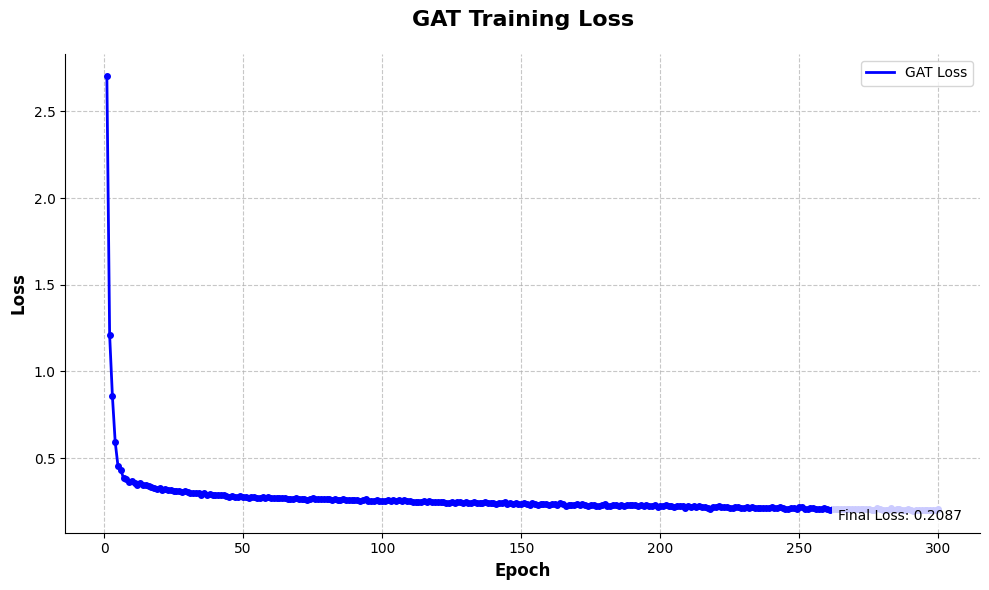

2025-10-22 15:45:17 - INFO - scLightGAT.training.model_manager - scLightGAT prediction completed
2025-10-22 15:45:18 - INFO - scLightGAT.pipeline - [TRAIN MODE] Training pipeline completed. Saved to: /home/dslab_cth/scLightGAT/results/GSE153935/adata_with_predictions.h5ad


In [ ]:
# --- 0) Reload your edited modules (English comments) ---
import importlib
import scLightGAT.preprocess.preprocess as preproc
import scLightGAT.preprocess.prediction_preprocess as predprep
import scLightGAT.training.model_manager as mm

importlib.reload(preproc)   # if you patched visualization_process to auto-detect X_pca_harmony
importlib.reload(predprep)
importlib.reload(mm)

# --- 1) Helper: attach Harmony PCs into obsm['X_pca_harmony'] ---
import scanpy as sc
import pandas as pd
import harmonypy as hm
# 1) Train with hierarchical mode ON
#    - DVAE on
#    - Use GAT refinement
#    - Adjust epochs per your GPU memory/time
from scLightGAT.pipeline import train_pipeline
train_pipeline(
    train_path="/home/dslab_cth/scLightGAT/data/Integrated_training/train.h5ad",
    test_path ="/home/dslab_cth/scLightGAT/data/Independent_testing/GSE153935.h5ad",
    output_path="/home/dslab_cth/scLightGAT/results/GSE153935",
    model_dir  ="/home/dslab_cth/scLightGAT/models",
    train_dvae=True,        # enable DVAE for latent+HVG fusion
    use_gat=True,           # enable GAT refinement
    dvae_epochs=3,         # or your previous stable setting
    gat_epochs=300,         # as you used before
    hierarchical=True       # turn on hierarchical training
)

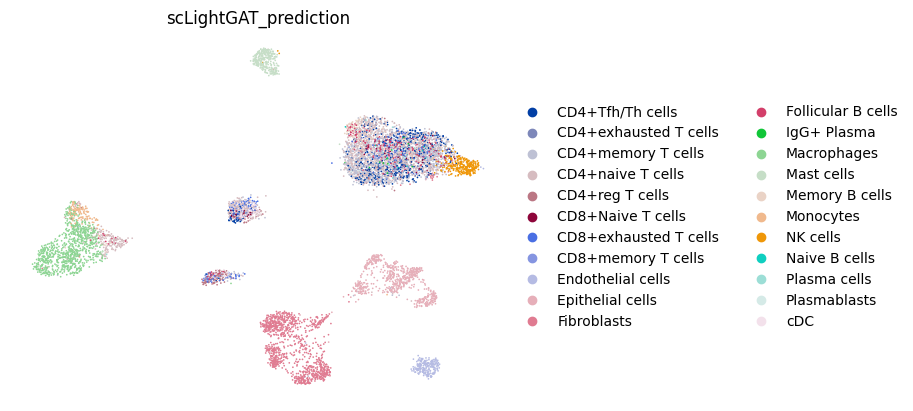

In [ ]:
adata = sc.read_h5ad("/home/dslab_cth/scLightGAT/results/GSE153935/adata_with_predictions.h5ad")
sc.pl.umap(adata,color=['subtype_pred_final'],title=['scLightGAT_prediction'],frameon = False, legend_loc = 'right margin',save=True,size =6)

In [ ]:
adata

AnnData object with n_obs × n_vars = 8030 × 851
    obs: 'sample_id', 'Celltype_training', 'Data_source', 'Cancer_type', 'LightGBM_prediction', 'scLightGAT_prediction', 'leiden', 'GAT_pred', 'subtype_pred_lightgbm', 'subtype_pred_final', 'prediction_path'
    uns: 'GAT_pred_colors', 'leiden', 'neighbors', 'pca', 'umap', 'scLightGAT_prediction_colors'
    obsm: 'LightGBM_probs', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log_transformed'
    obsp: 'connectivities', 'distances'